# Benchmarking

## Description

This notebook compares the quality of algorithms in `Roerich` library.

We use “WISDM Smartphone and Smartwatch Activity and Biometrics Dataset” [1, 2], prepared by the Wireless Sensor Data Mining (WISDM) Lab in the Department of Computer and Information Science of Fordham University. The dataset includes data from the accelerometer and gyroscope sensors of a smartphone and smartwatch collected as 51 subjects performed 18 diverse activities of daily living.  Each activity was performed for 3 minutes, so that each subject contributed 54 minutes of data. These activities include basic ambulation-related activities (e.g., walking, jogging, climbing stairs), hand-based activities of daily living (e.g., brushing teeth, folding clothes), and various eating activities (eating pasta, easting chips).

Each subject had a smartwatch placed on his/her dominant hand and a smartphone in their pocket. The data collection was controlled by a custom-made app that ran on the smartphone and smartwatch. The sensor data was collected at a rate of 20 Hz (i.e., every 50ms) from the accelerometer and gyroscope on both the smartphone and smartwatch, yielding four total sensors.

- [1] Weiss, Gary. (2019). WISDM Smartphone and Smartwatch Activity and Biometrics Dataset . UCI Machine Learning Repository. [[link]](https://archive-beta.ics.uci.edu/ml/datasets/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset)

- [2] Weiss, Gary & Yoneda, Kenichi & Hayajneh, Thaier. (2019). Smartphone and Smartwatch-Based Biometrics Using Activities of Daily Living. IEEE Access. PP. 1-1. [[DOI]](http://dx.doi.org/10.1109/ACCESS.2019.2940729).


## Data Download

The dataset is stored in UCI Machine Learning Repository and available for download via this [link](https://archive-beta.ics.uci.edu/ml/datasets/wisdm+smartphone+and+smartwatch+activity+and+biometrics+dataset).

In [1]:
#!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip
#!unzip -o -q wisdm-dataset.zip

In this example, we use data from a smartwatch accelerometer collected from one subject. The data file contains the following columns:

- **id:** uniquely identifies the subject. Rand: 1600 - 1650;
- **activity:** identifies a specific activity. Range: A-S (no “N” value);
- **timestamp:** Linux time;
- **x:** sensor value for x axis. May be positive or negative;
- **y:** same as x but for y axis;
- **z:** same as x but for z axis;

Let’s download the dataset and read a sample.

In [3]:
#import of basic libraties
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import roerich

In [4]:
# helping function for reading the data
def remove_char(fname):
    with open(fname, "r") as f:
        flist = f.readlines()
        flist = [s.replace(';', '') for s in flist]
    with open(fname[:-4] + '_debug.txt', "w") as f:
        f.writelines(flist)

In [5]:
# path to a file in the dataset
data_path = "wisdm-dataset/raw/watch/accel/data_1600_accel_watch.txt"

remove_char(data_path)

In [6]:
# read the data
cols = ["id", "activity", "timestamp", "x", "y", "z"]
data = pd.read_csv(data_path[:-4] + '_debug.txt', names=cols)
data.head()

,id,activity,timestamp,x,y,z
0,1600,A,90426708196641,7.091625,-0.591667,8.195502
1,1600,A,90426757696641,4.972757,-0.158317,6.696732
2,1600,A,90426807196641,3.253720,-0.191835,6.107758
3,1600,A,90426856696641,2.801216,-0.155922,5.997625
4,1600,A,90426906196641,3.770868,-1.051354,7.731027


## Preprocessing

We will use only sensor measurements and activity labels. So, let’s define the input matrix X and the label vector y. We will take every 20'th observation in order to speed up the computation.


In [7]:
#Taking only every 20th observation
X = data[['x', 'y', 'z']].values[::20]
y = data['activity'].values[::20]

However, we do not need the activity labels by itself, but moments of the activity changes. We consider them as change points of the signal, and our goal is to detect them.


In [8]:
# transform activity labels into change point positions
def get_true_cpds(y):
    cps_true = []
    for i in range(1, len(y)):
        if y[i] != y[i-1]:
            cps_true.append(i)
    return np.array(cps_true)

In [9]:
# get true change point positions
cps_true = get_true_cpds(y)

Then, we preprocess the time series using `StandardScaler`. It is not mandatory in general case, but sometimes can be useful :). Besides this, we add some noise to our signal. This hack is a regularization technique that helps to reduce sensitivity of the change point detection methods. It decreases the number of change points within one activity.


In [12]:
from sklearn.preprocessing import StandardScaler

# scale the signal
ss = StandardScaler().fit(X)
X_ss = ss.transform(X)

# add noise for regularization
X_ss += np.random.normal(0, 0.1, X_ss.shape)

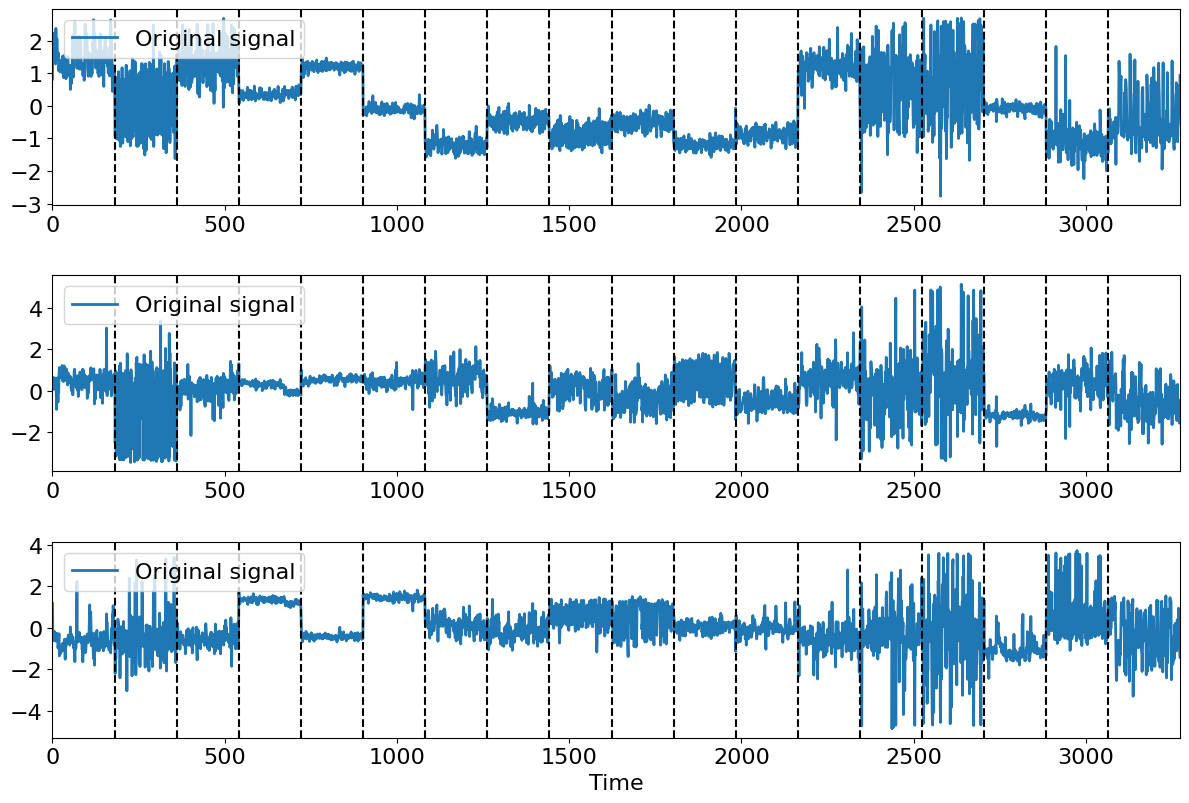

In [13]:
roerich.display(X_ss, cps_true)

## Comparison of algorithms

In this section we will compare 6 algorithms from the `Roerich` library.

In [53]:
#Default parameters (taken from `Usage` tab in documentation)

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from roerich.algorithms import GBDTRuLSIFRegressor

base_clf = QuadraticDiscriminantAnalysis()
base_reg = GBDTRuLSIFRegressor(n_estimators=10)
base_window_size = 100
base_periods = 1
base_n_runs = 1
base_step = 1
base_n_splits = 5
base_alpha = 0.2
base_n_epochs = 10
base_lr = 0.01
base_lam = 0.0001
base_lag_size = 100
base_optimizer = 'Adam'

In [54]:
from roerich.algorithms import ChangePointDetectionRuLSIF, ChangePointDetectionClassifier, \
                               EnergyDistanceCalculator, ChangePointDetectionClassifierCV, \
                               OnlineNNRuLSIF, OnlineNNClassifier


algorithms = [(ChangePointDetectionClassifier(base_classifier=base_clf, metric='KL_sym',
                                              periods=base_periods, window_size=base_window_size,
                                              step=base_step, n_runs=base_n_runs), 'Classifier'),

              (ChangePointDetectionClassifierCV(base_classifier=base_clf, metric='KL_sym',
                                                periods=base_periods, window_size=base_window_size,
                                                step=base_step, n_splits=base_n_splits), 'Classifier + CV'),

              (ChangePointDetectionRuLSIF(base_regressor=base_reg, metric='PE',
                                          periods=base_periods, window_size=base_window_size,
                                          step=base_step, n_runs=base_n_runs), 'RuLSIF'),

              (OnlineNNRuLSIF(alpha=base_alpha, net='default', scaler='default',
                              periods=base_periods, window_size=base_window_size,
                              lag_size=100, step=base_step, n_epochs=base_n_epochs,
                              lr=base_lr, lam=base_lam, optimizer=base_optimizer), 'Online NN RuLSIF'),

              (OnlineNNClassifier(net='default', scaler='default', metric='KL_sym',
                                  periods=base_periods, window_size=base_window_size,
                                  lag_size=base_lag_size, step=base_step, n_epochs=base_n_epochs,
                                  lr=base_lr, lam=base_lam, optimizer=base_optimizer), 'Online NN Classifier'),

              (EnergyDistanceCalculator(window_size=base_window_size,
                                        step=base_step), 'Energy Distance Calculator')]

We will write a function that takes array of true change-points and predicted ones and calculates a couple of metrics: Precision, Recall, PR-auc, PE\_score, PE, PE\_sym, Wasserstein.

In [55]:
from roerich.metrics import precision_recall_scores, precision_recall_curve, auc_score
from roerich.metrics.metrics import PE_score, PE, PE_sym, Wasserstein

metrics = [PE_score, PE, PE_sym, Wasserstein]

def calculate_metrics(cps_true, cps_pred, score):

    precision, recall = precision_recall_scores(cps_true, cps_pred, window=base_window_size)

    results = [precision, recall]

    thr, precision, recall = precision_recall_curve(cps_true, cps_pred, score[cps_pred], window=base_window_size) #I am not sure
    results.append(auc_score(thr, precision, recall))

    for metric in metrics:
        results.append(metric(cps_pred, cps_true))

    return results

The results will be stored in a dataframe: the columns are different metrics and the rows are the results for different algorithms.

In [56]:
df = pd.DataFrame(columns=['algorithm', 'precision', 'recall', 'PR-auc', 'PE_score', 'PE', 'PE_sym', 'Wasserstein'])
df.set_index('algorithm', inplace=True)
df

,precision,recall,PR-auc,PE_score,PE,PE_sym,Wasserstein
algorithm,,,,,,,


In [ ]:
#Iterating through all the algorithms

for cpd, alg_name in algorithms:
    score, cps_pred = cpd.predict(X_ss)
    df.loc[alg_name] = calculate_metrics(cps_true, cps_pred, score)

In [58]:
df

,precision,recall,PR-auc,PE_score,PE,PE_sym,Wasserstein
algorithm,,,,,,,
Classifier,1.0,0.941176,0.970588,-1.614582e+06,0.0,0.0,56.198529
Classifier + CV,1.0,1.000000,1.000000,-1.710447e+06,0.0,0.0,-1.529412
RuLSIF,1.0,1.000000,1.000000,-1.705240e+06,0.0,0.0,0.235294
Online NN RuLSIF,0.9,0.529412,0.734967,-2.244250e+06,0.0,0.0,-228.476471
Online NN Classifier,1.0,0.470588,0.735294,-2.183146e+06,0.0,0.0,-280.426471
Energy Distance Calculator,1.0,0.941176,0.970588,-1.616377e+06,0.0,0.0,55.448529
